## Modelling for Wine Quality

### Feature Selection

**Potential Discard Variables**
- total sulfur dioxide
- pH
- sulphates

**Initial Features**

fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol

In [3]:
# Install Dependencies

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
from scikeras.wrappers import KerasRegressor
import tensorflow as tf

In [4]:
df = pd.read_csv(os.path.join('data', 'winequality.csv'))
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [15]:
raw_features = [
    'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'
]

derived_features = [
    ('total acidity', lambda X: X['fixed acidity'] + X['volatile acidity'])
]

drop_features = ['fixed acidity', 'volatile acidity', 'pH', 'total sulfur dioxide']

target = 'quality'

### Pre-processing

In [16]:
X = df[raw_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

In [28]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, raw_features, derived_features={}, drop_features=[]):
        self.raw_features = raw_features
        self.derived_features = derived_features
        self.drop_features = drop_features
        self.final_features = []

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X = X[self.raw_features].copy()

        for feat, derive in self.derived_features:
            X[feat] = derive(X)
        
        self.final_features = [col for col in X.columns if col not in self.drop_features]
        return X[self.final_features]
    
    def get_feature_names_out(self):
        if self.final_features:
            return self.final_features
        else:
            cols = [col for col in self.raw_features if col not in self.drop_features]
            for feat, _derive in self.derived_features:
                if feat not in cols:
                    cols.append(feat)
            return cols

In [ ]:
def trim_outliers(X):
    X = X.copy()
    for col in outliers: # type: ignore
        Q1, Q3 = np.percentile(X[col], [25, 75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 2 * IQR, Q3 + 2 * IQR
        X[col] = np.clip(X[col], lower, upper)
    return X

In [30]:
def build_mlp(input_dim, dropout=0.05, **kwargs):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=(input_dim,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

In [ ]:
feature_engineer = FeatureEngineer(raw_features, derived_features, drop_features)

X_train_fe = feature_engineer.transform(X_train)
final_features = feature_engineer.get_feature_names_out()

outliers = ['total acidity', 'citric acid', 'chlorides', 'free sulfur dioxide', 'density', 'sulphates']
right_skew = ['residual sugar', 'alcohol']
exclude = set(outliers + right_skew)
others = [col for col in final_features if col not in exclude]

outlier_transformer = Pipeline(steps=[
    ('trim', FunctionTransformer(trim_outliers, validate=False)),
    ('scale', StandardScaler())
])

log_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(np.log1p, validate=False)),
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('outliers', outlier_transformer, outliers),
        ('log', log_transformer, right_skew),
        ('features', StandardScaler(), others)
    ]
)

lr_model = LinearRegression()

ridge_model = Ridge(
    alpha=1,
    random_state=37
)

lasso_model = Lasso(
    alpha=0.1,
    tol=0.0001,
    max_iter=1000,
    random_state=37
)

rfr_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=5,
    min_samples_split=12,
    min_samples_leaf=4,
    bootstrap=True,
    max_features=1,
    random_state=37,
    n_jobs=-1
)

gbr_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    min_samples_leaf=4,
    min_samples_split=12,
    random_state=37
)

# n_estimators=150,439
# learning_rate=0.1,0.13
# max_depth=3,7
# subsample=0.9,0.94
# min_samples_leaf=3,4
# min_samples_split=9,4

nn = KerasRegressor(
    model=build_mlp,
    input_dim=len(final_features),
    dropout=0.03,
    epochs=200,
    batch_size=64,
    verbose=1,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0.03, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)
    ]
)

xgbr_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0,
    reg_lambda=1,
    random_state=37,
    objective='reg:absoluteerror'
)

model = Pipeline(steps=[
    ('feature_engineer', feature_engineer),
    ('preprocessor', preprocessor),
    ('model', nn)
])

### Training

In [49]:
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

mae = mean_absolute_error(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_predict)
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X.shape[1] - 1)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.3f}")
print(f"Adjusted R2: {adjusted_r2:.3f}")

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.5605 - mean_absolute_error: 2.6546 - val_loss: 2.1941 - val_mean_absolute_error: 1.1753 - learning_rate: 0.0010
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5322 - mean_absolute_error: 0.9776 - val_loss: 1.4857 - val_mean_absolute_error: 0.9477 - learning_rate: 0.0010
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0263 - mean_absolute_error: 0.7961 - val_loss: 0.9663 - val_mean_absolute_error: 0.7731 - learning_rate: 0.0010
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7970 - mean_absolute_error: 0.6939 - val_loss: 0.9005 - val_mean_absolute_error: 0.7371 - learning_rate: 0.0010
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7182 - mean_absolute_error: 0.6657 - val_loss: 0.7596 - val_mean_absolute_error: 0.6782 - learning_rate: 0.0010
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6615 - mean_absolute_error: 0.6364 - val_loss: 0.7187 - val_mean_absolute

In [51]:
neg_mae = cross_val_score(model, X, y, cv=10, scoring='neg_mean_absolute_error')
mae_scores = -neg_mae

print(f"Cross-validated MAE: {mae_scores.mean():.2f} ± {mae_scores.std():.2f}")

Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.4263 - mean_absolute_error: 3.2434 - val_loss: 1.9582 - val_mean_absolute_error: 1.0962 - learning_rate: 0.0010
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7795 - mean_absolute_error: 1.0533 - val_loss: 1.2221 - val_mean_absolute_error: 0.8531 - learning_rate: 0.0010
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2046 - mean_absolute_error: 0.8614 - val_loss: 0.8971 - val_mean_absolute_error: 0.7241 - learning_rate: 0.0010
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9489 - mean_absolute_error: 0.7630 - val_loss: 0.6730 - val_mean_absolute_error: 0.6189 - learning_rate: 0.0010
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7951 - mean_absolute_error: 0.6969 - val_loss: 0.7878 - val_mean_absolute_error: 0.6971 - learning_rate: 0.0010
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7041 - mean_absolute_error: 0.6579 - val_loss: 0.6619 - val_mean_absolute

In [64]:
data = pd.DataFrame([[6.2,0.53,0.02,0.9,0.035,6.0,81.0,0.99234,3.24,0.35,9.5]], columns=raw_features)
prediction = model.predict(data)
print(f"Predicted wine quality: {prediction[0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted wine quality: 4.39


In [161]:
param_dist_gbr = {
    'model__n_estimators': randint(100, 500),
    'model__learning_rate': uniform(0.01, 0.19),
    'model__max_depth': randint(2, 8),
    'model__subsample': uniform(0.5, 0.5),
    'model__min_samples_split': randint(4, 12),
    'model__min_samples_leaf': randint(2, 6)
}

rs = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist_gbr,
    n_iter=1000,
    scoring='neg_mean_absolute_error',
    cv=5,
    random_state=37,
    verbose=1,
    n_jobs=-1
)

rs.fit(X_train, y_train)

print("\nBest params from Randomized Search:", rs.best_params_)
print(f"Best MAE from Randomized Search: {-rs.best_score_:.4f}")

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits

Best params from Randomized Search: {'model__learning_rate': np.float64(0.13362265805249987), 'model__max_depth': 7, 'model__min_samples_leaf': 4, 'model__min_samples_split': 4, 'model__n_estimators': 439, 'model__subsample': np.float64(0.9448342195691182)}
Best MAE from Randomized Search: 0.4514


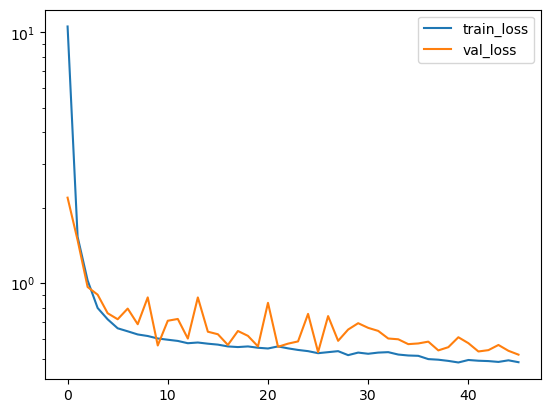

In [65]:
h: KerasRegressor = model.named_steps['model'].history_
plt.plot(h['loss'], label='train_loss')
plt.plot(h['val_loss'], label='val_loss')
plt.yscale('log')
plt.legend(); plt.show()

In [ ]:
fe = model.named_steps['feature_engineer']
df_fe = fe.transform(df)
df_before = df_fe[outliers]
df_after = trim_outliers(df_before)

fig, axes = plt.subplots(len(outliers), 2, figsize=(12, len(outliers) * 4))
for i, feature in enumerate(outliers):
    # Before trimming
    sns.boxplot(data=df_before, x=feature, ax=axes[i, 0])
    axes[i, 0].set_title(f'{feature} Before Trimming')

    # After trimming
    sns.boxplot(data=df_after, x=feature, ax=axes[i, 1])
    axes[i, 1].set_title(f'{feature} After Trimming')

plt.tight_layout()

In [ ]:
# Linear Regression Models

coefs = model.named_steps['model'].coef_
coef_df = pd.DataFrame({
    'Feature': final_features,
    'Coefficient': coefs,
    'Absolute Coefficient': np.abs(coefs)
}).sort_values(by='Absolute Coefficient', ascending=False)

print(coef_df.head(12))

               Feature  Importance
8              alcohol    0.244126
1     volatile acidity    0.135487
4            chlorides    0.106045
7            sulphates    0.095345
5  free sulfur dioxide    0.095135
6              density    0.089436
3       residual sugar    0.082455
2          citric acid    0.078501
0        fixed acidity    0.073470


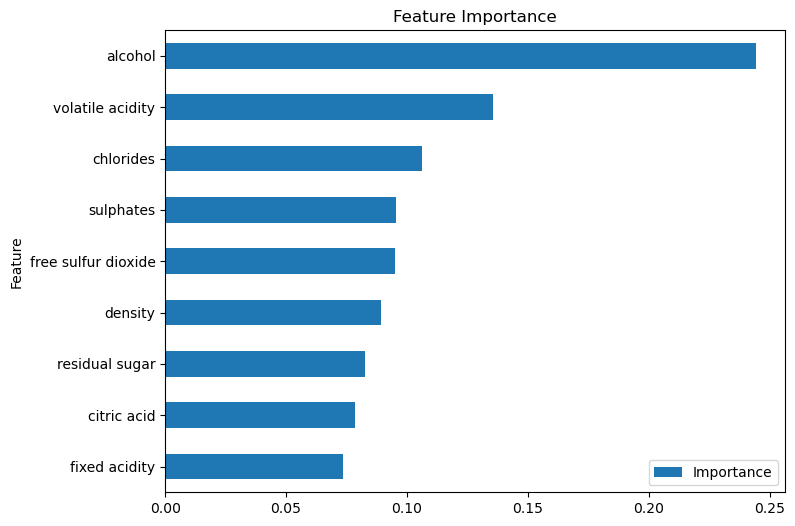

In [ ]:
# Tree-based Models

importances = model.named_steps['model'].feature_importances_

import_df = pd.DataFrame({
    'Feature': final_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(import_df.head(10))

import_df.head(12).plot(kind='barh', x='Feature', y='Importance', figsize=(8, 6))
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

### Visualisations

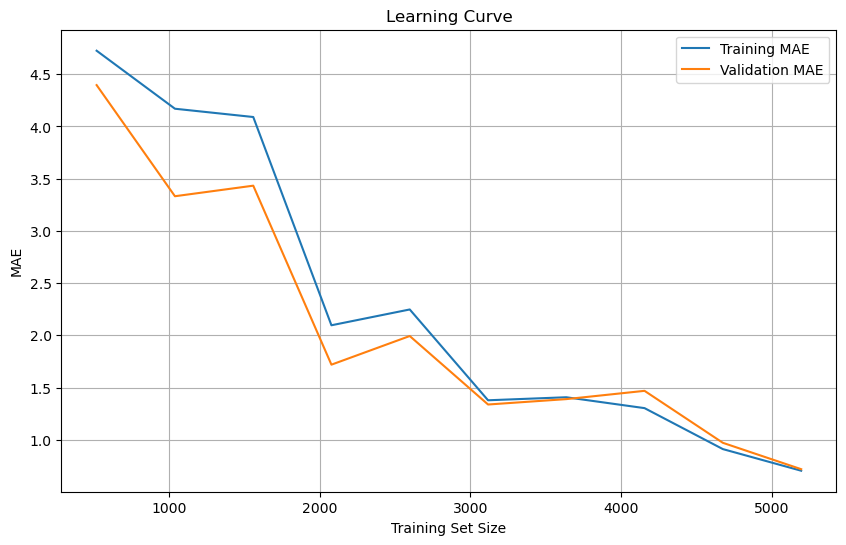

In [66]:
# All

train_sizes, train_scores, val_scores = learning_curve(
    model, X, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = -np.mean(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training MAE')
plt.plot(train_sizes, val_scores_mean, label='Validation MAE')
plt.xlabel('Training Set Size')
plt.ylabel('MAE')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

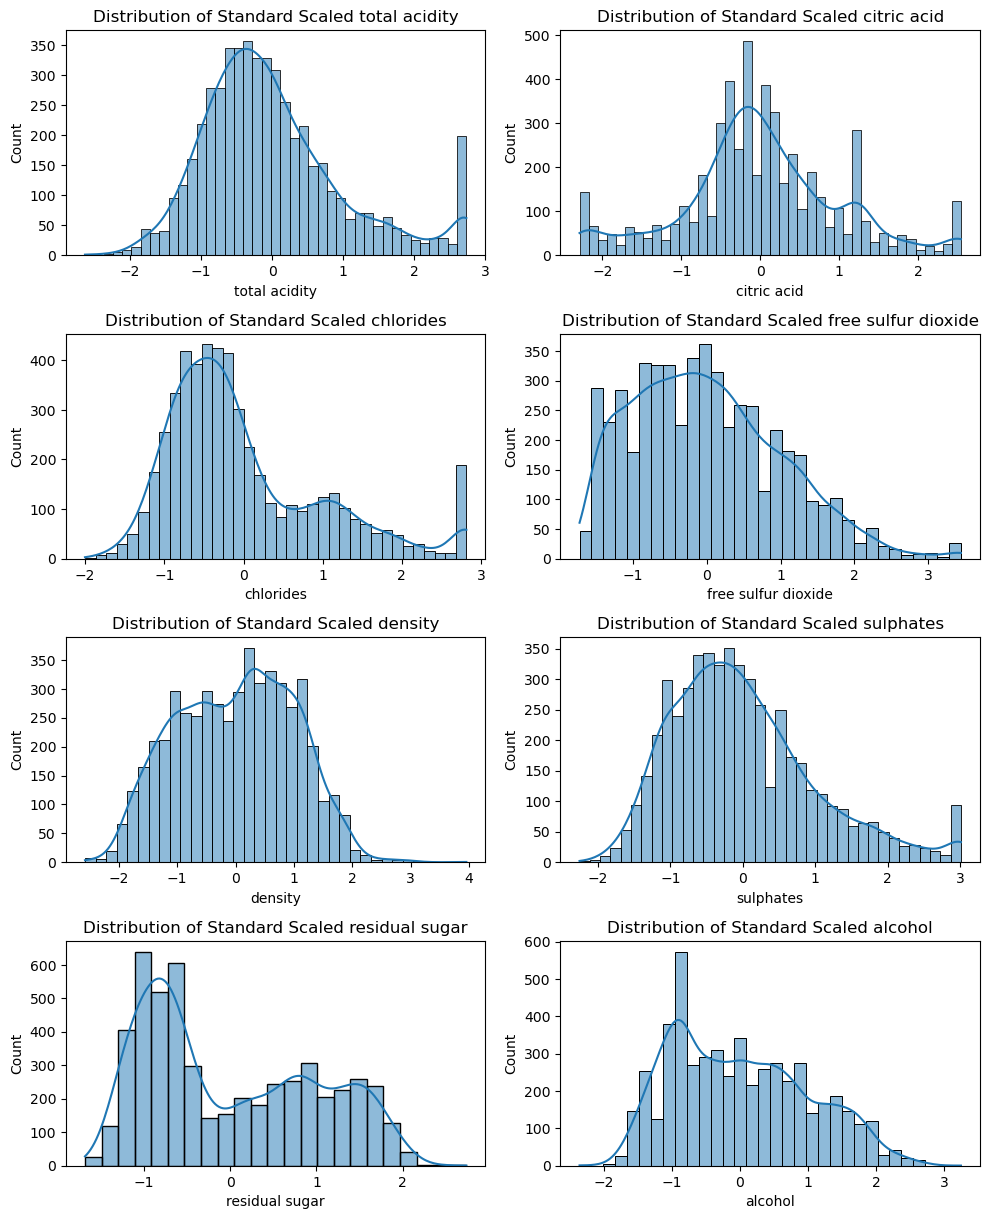

In [ ]:
X_train_transformed = model.named_steps['preprocessor'].transform(
    model.named_steps['feature_engineer'].transform(X_train)
)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=final_features)

plt.figure(figsize=(10, len(final_features) * 3))
for i, feat in enumerate(final_features, 1):
    plt.subplot(len(final_features), 2, i)
    sns.histplot(X_train_transformed_df[feat], kde=True)
    plt.title(f'Distribution of Standard Scaled {feat}')

plt.tight_layout()